# Example for processing proximity data collected by a hub

The badges scans for other badges and iBeacons every time interval. The time interval, called time_slice in this example, is set by the hub and usually configured for 60 seconds.

Each scan appears as a JSON object, containing the member key of the scanning badge, it's MAC address, timestamp of the scan, voltage at the time of the scan, and a list of other bluetooth devices picked up by the scan. 

In order to preserve storage space, we do not save the MAC addresses of the the badges found in th scan. Instead, we store only the badge ID - a 16-bit unique identifier that each badge broadcasts. This ID can be set manually, but at the time of writing this example, the ID is created using CRC16 based on the MAC address. 

Since members may change their badges during the experiment, it's important to perform the analysis using member keys.

Code credits - Xavier Lambein

In [5]:
import os, sys
import logging
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

from collections import Counter
%run Preprocessing.ipynb
# Import the data analysis tools
#import openbadge_analysis as ob
#import openbadge_analysis.preprocessing
#import openbadge_analysis.core

SELECTED_BEACON = 12

In [2]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.0.3
numpy            : 1.16.2
pytz             : 2018.9
dateutil         : 2.8.0
pip              : 20.0.2
setuptools       : 46.1.3
Cython           : 0.29.6
pytest           : 4.3.1
hypothesis       : None
sphinx           : 1.8.5
blosc            : None
feather          : None
xlsxwriter       : 1.1.5
lxml.etree       : 4.3.2
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10
IPython          : 7.4.0
pandas_datareader: None
bs4              : 4.7.1
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.3.2
matplotlib   

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to your local time.

In [6]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filenames = []

# get all files from the folder
for i in range(1, 18):
    if i < 10:
        filename = 'CTSIserver{:02d}_proximity_2019-06-01.txt'.format(i)
    else:
        filename = 'CTSIserver{}_proximity_2019-06-01.txt'.format(i)
        
    proximity_data_filenames.append(filename)
    
members_metadata_filename = "Member-2019-05-28.csv"
beacons_metadata_filename = "location table.xlsx"
attendees_metadata_filename = "Badge assignments_Attendees_2019.xlsx"
data_dir = "../proximity_2019-06-01/"

# Pre-processing

First, we load two lists that will help us with some of the analysis: list of membmers and list of location beacons

In [7]:
# get all metadata
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
members_metadata.dropna()
beacons_metadata = pd.read_excel(data_dir+beacons_metadata_filename, sheet_name='Sheet1')
attendees_metadata = pd.read_excel(data_dir+attendees_metadata_filename)
# Calculating the id of the beacon based on it's MAC address
# beacons_metadata['id'] = beacons_metadata.apply(
#     lambda row: ob.core.mac_address_to_id(row['badge_address']),
#     axis=1
# )

## beacons_metadata

We create a translation table between the badge ID and member key. This is done based on the data itself, since it should contain data from all the badges that take part in the study. 

Note that we create a <id,member key> pair for ever time bin. While this is not necessary at this point, it allows this mapping to change (for example, if a badge is re-assigned to a different member).

In [8]:
idmaps = []
# get the proximity data from the file, raw data
for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        #idmaps.append(ob.preprocessing.id_to_member_mapping(f, time_bins_size, tz=time_zone))
        idmaps.append(id_to_member_mapping(f, time_bins_size, tz=time_zone))
tmp_idmaps = idmaps[0]
for i in range(1, len(idmaps)):
    tmp_idmaps = pd.concat([tmp_idmaps, idmaps[i]])

<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>
<class '_io.TextIOWrapper'>


In [9]:
idmap_beacon = tmp_idmaps
startmin = 25

for i in beacons_metadata[['key', 'id']].iterrows():
    beacon_id = i[1][1]
    beacon_key = i[1][0]
    
    tmp = pd.DataFrame(['2019-06-01 14:{}:00-04:00'.format(startmin), beacon_id, beacon_key]).transpose()
    startmin += 1
    tmp.columns = ['datetime', 'id', 'member']
    idmap_beacon = pd.concat([idmap_beacon, tmp])

Using this translation table and the proximity data, we can create a list of "pings" - every time two badges were in close proximity

In [10]:
m2badges = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        m2badges.append(member_to_badge_proximity(f, time_bins_size, tz=time_zone))
        
tmp_m2badges = m2badges[0]

for i in range(1, len(m2badges)):
    tmp_m2badges = pd.concat([tmp_m2badges, m2badges[i]])

Since a badge can either be a badge worn by a participant, or a location beacon, we split the dataset into member-to-member (for network graphs) and member-to-beacon (for localization)

In [11]:
# Member to member
m2ms = []
for (m2badge, idmap) in zip(m2badges, idmaps):
    m2ms.append(member_to_member_proximity(m2badge, idmap))
    
tmp_m2ms = m2ms[0]
for i in range(1, len(m2ms)):
    tmp_m2ms = pd.concat([tmp_m2ms, m2ms[i]])

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 09:27:00-04:00 2J8MAVR3AS MVYAANIGBF     -79.0          -79.000000   
2019-06-01 09:28:00-04:00 2J8MAVR3AS MVYAANIGBF     -80.0          -80.000000   
2019-06-01 09:29:00-04:00 2J8MAVR3AS MVYAANIGBF     -77.0          -77.000000   
2019-06-01 09:30:00-04:00 2J8MAVR3AS MVYAANIGBF     -79.0          -79.000000   
2019-06-01 09:31:00-04:00 2J8MAVR3AS MVYAANIGBF     -77.0          -77.000000   
...                                                   ...                 ...   
2019-06-01 23:59:00-04:00 OXARTM08UP RWQC6PANDT     -51.0          -52.714286   
                                     VG7WS97T31     -55.0          -57.000000   
                          OXWXYDP970 VG7WS97T31     -61.0          -61.000000   
                          RWQC6PANDT VG7WS97T31     -56.0          -56.000000   
                            

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:00:00-04:00 6FI0Z5BPM9 BGDAR6QAZ4     -44.0          -44.500000   
                                     XWX0GF9XXM     -51.0          -51.333333   
                                     YOMIDAL72I     -52.0          -52.333333   
                          BGDAR6QAZ4 O362RWVN8T     -46.0          -47.250000   
                                     PNVAQ4FSKG     -45.0          -45.800000   
...                                                   ...                 ...   
2019-06-01 23:59:00-04:00 MIJ7PMFGS1 XWX0GF9XXM     -57.0          -57.000000   
                          N7X3CND9H8 PW0J7VQIB2     -55.0          -55.000000   
                                     YT7HBOM7D9     -44.0          -44.500000   
                          WO2LI35VPN XWX0GF9XXM     -58.0          -58.000000   
                          XW

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 01:42:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0               -52.0   
2019-06-01 01:43:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0               -52.0   
2019-06-01 01:44:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0               -52.0   
2019-06-01 01:45:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0               -52.0   
2019-06-01 01:46:00-04:00 DGDZ6VUX8C YKLASWLX12     -52.0               -52.0   
...                                                   ...                 ...   
2019-06-01 14:46:00-04:00 E68XQWH83K T7L77Z40R9     -85.0               -86.0   
2019-06-01 14:47:00-04:00 9S9NV5HOW4 E68XQWH83K     -77.0               -77.0   
                                     T7L77Z40R9     -69.0               -70.0   
                          E68XQWH83K T7L77Z40R9     -76.0               -77.0   
2019-06-01 14:48:00-04:00 E6

                                                 rssi_max  rssi_weighted_mean  \
datetime                  member1    member2                                    
2019-06-01 00:42:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:43:00-04:00 2ZNIW64VDH OHRS4FV3S7     -45.0          -45.333333   
2019-06-01 00:44:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:45:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
2019-06-01 00:46:00-04:00 2ZNIW64VDH OHRS4FV3S7     -46.0          -46.000000   
...                                                   ...                 ...   
2019-06-01 15:19:00-04:00 KK4XOZN9VJ O2X9FPB1Y1     -45.0          -45.000000   
                          MKFK72B1N6 O2X9FPB1Y1     -46.0          -46.000000   
2019-06-01 15:20:00-04:00 F4VB4QJ7G8 KK4XOZN9VJ     -44.0          -45.200000   
                          KK4XOZN9VJ O2X9FPB1Y1     -44.0          -45.142857   
                          MK

In [13]:
# Member to location beacon
m2bs = []
for m2badge in m2badges:
    m2bs.append(member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon']))
    
tmp_m2bs = m2bs[0]
for i in range(1, len(m2bs)):
    tmp_m2bs = pd.concat([tmp_m2bs, m2bs[i]])

 Member 5 closest beacons

In [14]:
m5cb = tmp_m2bs.reset_index().groupby(['datetime', 'member'])['rssi', 'beacon'] \
        .apply(lambda x: x.nlargest(5, columns=['rssi']) \
        .reset_index(drop=True)[['beacon']]).unstack()['beacon'].fillna(-1).astype(int)

D:\stupid_shit\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


# Clean the member to member data
## Some unused badages were in a box during the conference which generated noisy data

In [15]:
# match the badge ID in attendee data with the name in members 
attend_id = attendees_metadata['BADGE #'].values.astype('str').tolist()
member_id = members_metadata['name'].values.astype('str').tolist()
drop_member = []
for i in member_id:
    if i not in attend_id:
        drop_member.append(i)
drop_name = []
key_name = members_metadata['member'].values.astype('str').tolist()
value_id = members_metadata['name'].values.astype('str').tolist()
dic_name_id = dict(zip(key_name,value_id))
for i in dic_name_id:
    if dic_name_id[i] in drop_member:
        drop_name.append(i)

In [16]:
# delete the member to member records which does not have attendee information
drop_index = []
tmp_m2ms = tmp_m2ms.reset_index()
for index,row in tmp_m2ms.iterrows():
    if row['member1'] in drop_name:
        drop_index.append(index)
    elif row['member2'] in drop_name:
        drop_index.append(index)

In [17]:
tmp_m2ms = tmp_m2ms.drop(drop_index)

In [18]:
tmp_m2ms = tmp_m2ms.set_index(['datetime'])

# Background dataframe

In [19]:
# get a dataframe with the member badge Key and corresponding background field and affiliation
background = pd.DataFrame(columns=['name','badge','background','affiliation'])
background_affiliation = pd.DataFrame(columns=['name','badge','background','affiliation'])
background['name'] = members_metadata['member']
background['badge'] = members_metadata['BADGE IP']
for i in background['badge']:
    if i in attendees_metadata['BADGE IP'].values:
        a = background.loc[background['badge'] == i]
        b = attendees_metadata.loc[attendees_metadata['BADGE IP']==i]
        a['background'] = b['Cleaned Primary discipline/field of interest More generalized'].values
        a['affiliation'] = b['Affiliation'].values
        background_affiliation = pd.concat([background_affiliation, a])
    else:
        a = background.loc[background['badge']==i]
        background_affiliation = pd.concat([background_affiliation, a])

D:\stupid_shit\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\stupid_shit\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


# Heapmap of interaction between members over a certain period
### n * n array if the memebr is not present for each person, use the count_sum to represent. if not present, set  the sum to 0

In [20]:
import seaborn as sns; 
#sns.heatmap(hm, annot=True)

In [21]:
# get all the time periods that we are interested in
time_slice = slice('2019-06-01 10:00', '2019-06-01 10:00')
breakout1 = slice('2019-06-01 09:50', '2019-06-01 10:39')
breakout2 = slice('2019-06-01 10:40', '2019-06-01 11:30')
breakout3 = slice('2019-06-01 13:10', '2019-06-01 13:59')
breakout4 = slice('2019-06-01 14:00', '2019-06-01 14:50')
lunch = slice('2019-06-01 11:40','2019-06-01 13:00')
whole_session = slice('2019-06-01 9:05','2019-06-01 14:50')

In [22]:
# get the big data frame with members on the labels and interaction counts in the cells
period = tmp_m2ms.loc[whole_session]
period = period[period.rssi >= -76].copy()

name_1 = period['member1'].unique().tolist()
name_2 = period['member2'].unique().tolist()
all_name = name_1+name_2
all_name = set(all_name)
all_name = sorted(all_name)

hm = pd.DataFrame(columns=all_name)

# loop through the whole list:
for n in all_name:
    haha = []
    name_values = [0]*len(all_name)
    dimension_ = dict(zip(all_name,name_values))
    # get all the rows with one name in the name list
    t = period.loc[period['member1'] == n]
    t2 = t['member2'].unique()
    t2_values = [0]*len(t2)
    hahaha = dict(zip(t2,t2_values))
    
    for i in range(len(t2)):
        interacted = t.loc[t['member2'] == t2[i]]
        hahaha[t2[i]] = sum(interacted['count_sum'])
    for i in dimension_: 
        if i in hahaha:
            dimension_[i] = hahaha[i]
    #haha = dimension_.values()
    for i in all_name:
        haha.append(dimension_[i])
    temporary = pd.DataFrame([haha], columns = all_name)
    hm = pd.concat([hm, temporary],ignore_index = True)

In [23]:
# label each member by ther memeber's background field
label_background = []
label_aff = []
for i in all_name:
    j = background_affiliation.loc[background_affiliation['name']== i]
    k = j['background'].values.astype('str')
    k = k.item()
    o = j['affiliation'].values.astype('str')
    o = o.item()
    label_background.append(k)
    label_aff.append(o)

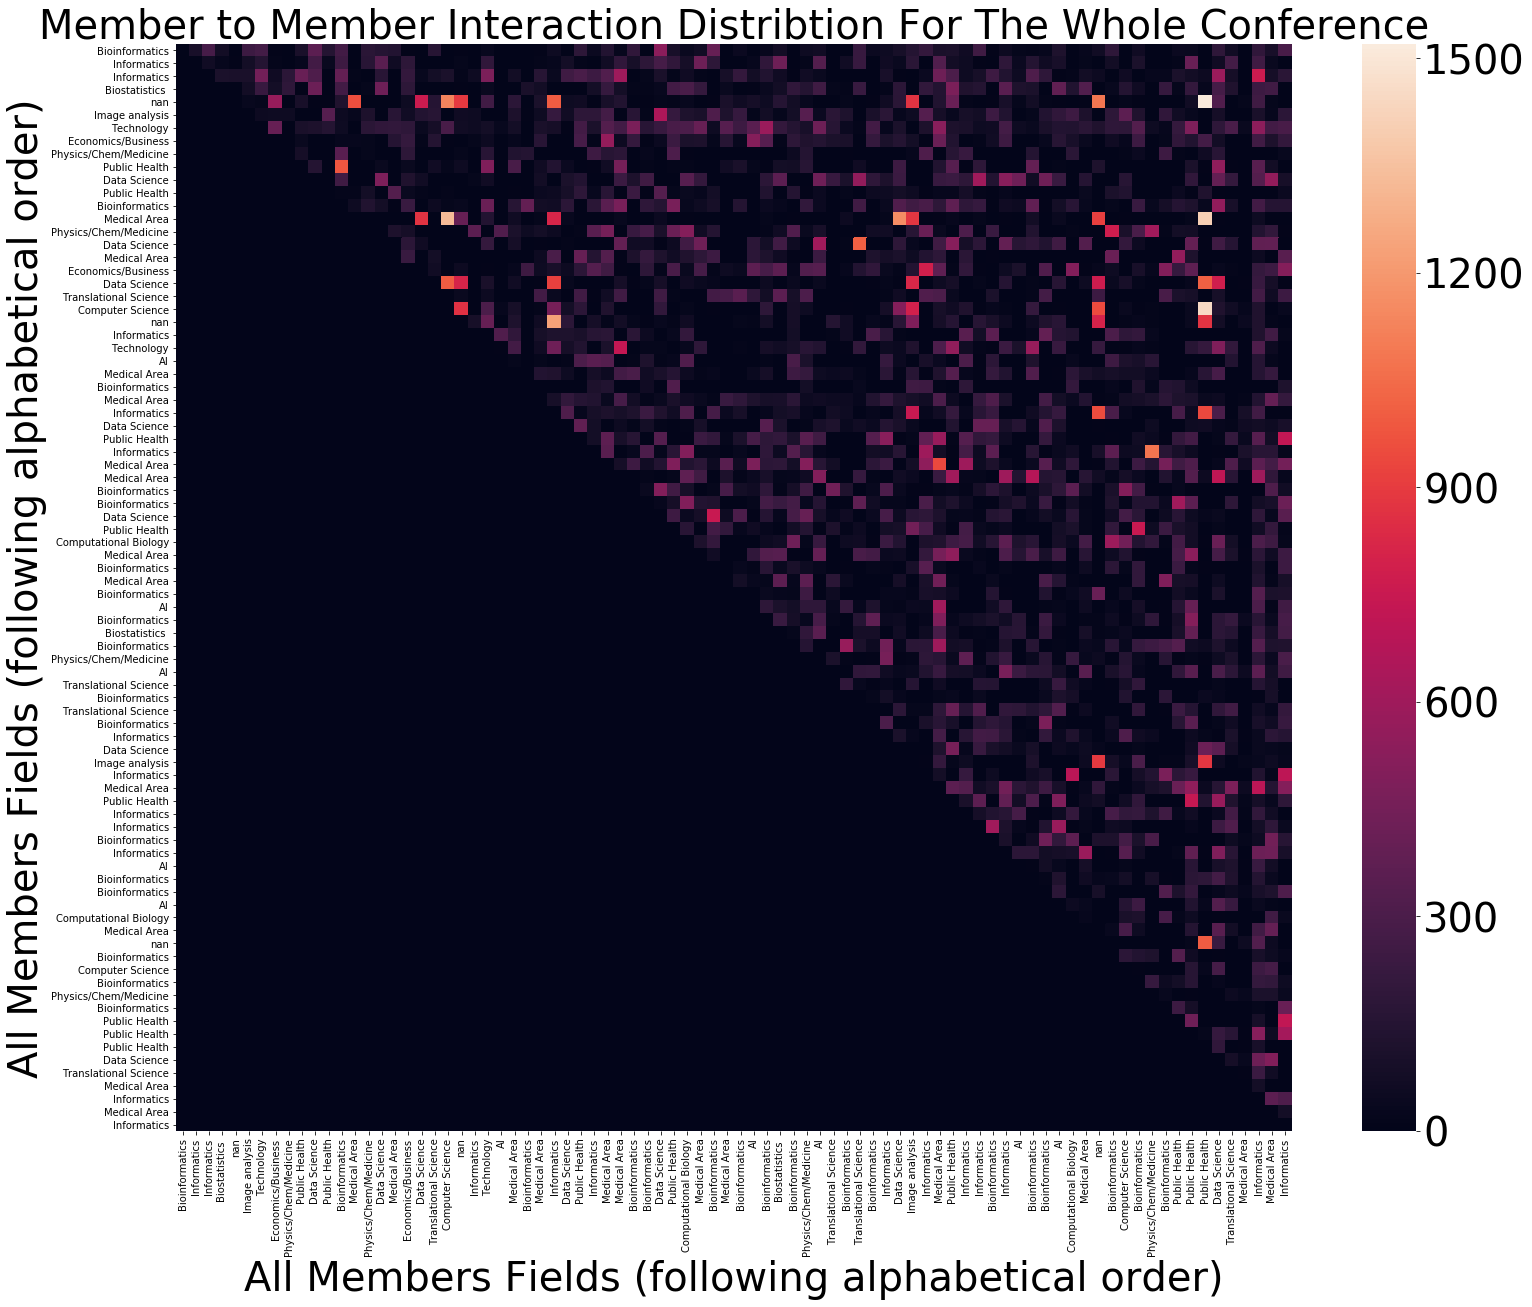

In [24]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8,8))
# Sample figsize in inches

plt.figure(figsize = (25,20))
hm_values = hm.values.astype(str).astype(float)
ax = sns.heatmap(hm_values, xticklabels= label_background, yticklabels= label_background)
plt.title('Member to Member Interaction Distribtion For The Whole Conference',fontsize = 40)
plt.xlabel('All Members Fields (following alphabetical order)',fontsize = 40)
plt.ylabel('All Members Fields (following alphabetical order)',fontsize = 40)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=40)

# Group by Major or affiliation 

In [25]:
# group each badge name with background field
name_major = dict(zip(background_affiliation['name'].values.astype('str').tolist(),
                      background_affiliation['background'].values.astype('str').tolist()))

In [26]:
hm['member_name'] = all_name

In [27]:
hm = hm.set_index('member_name')

In [28]:
# only take the ones with targeted background field
drop_col = []
target_major = 'Data Science'
hm_copy = hm
for index,row in hm.iterrows():
    if name_major[index] != target_major:
        hm_copy = hm_copy.drop(index)
        drop_col.append(index)
hm_copy = hm_copy.drop(drop_col,axis = 1)

Text(204.0, 0.5, 'All Data Science Member (Following alphabetical order)')

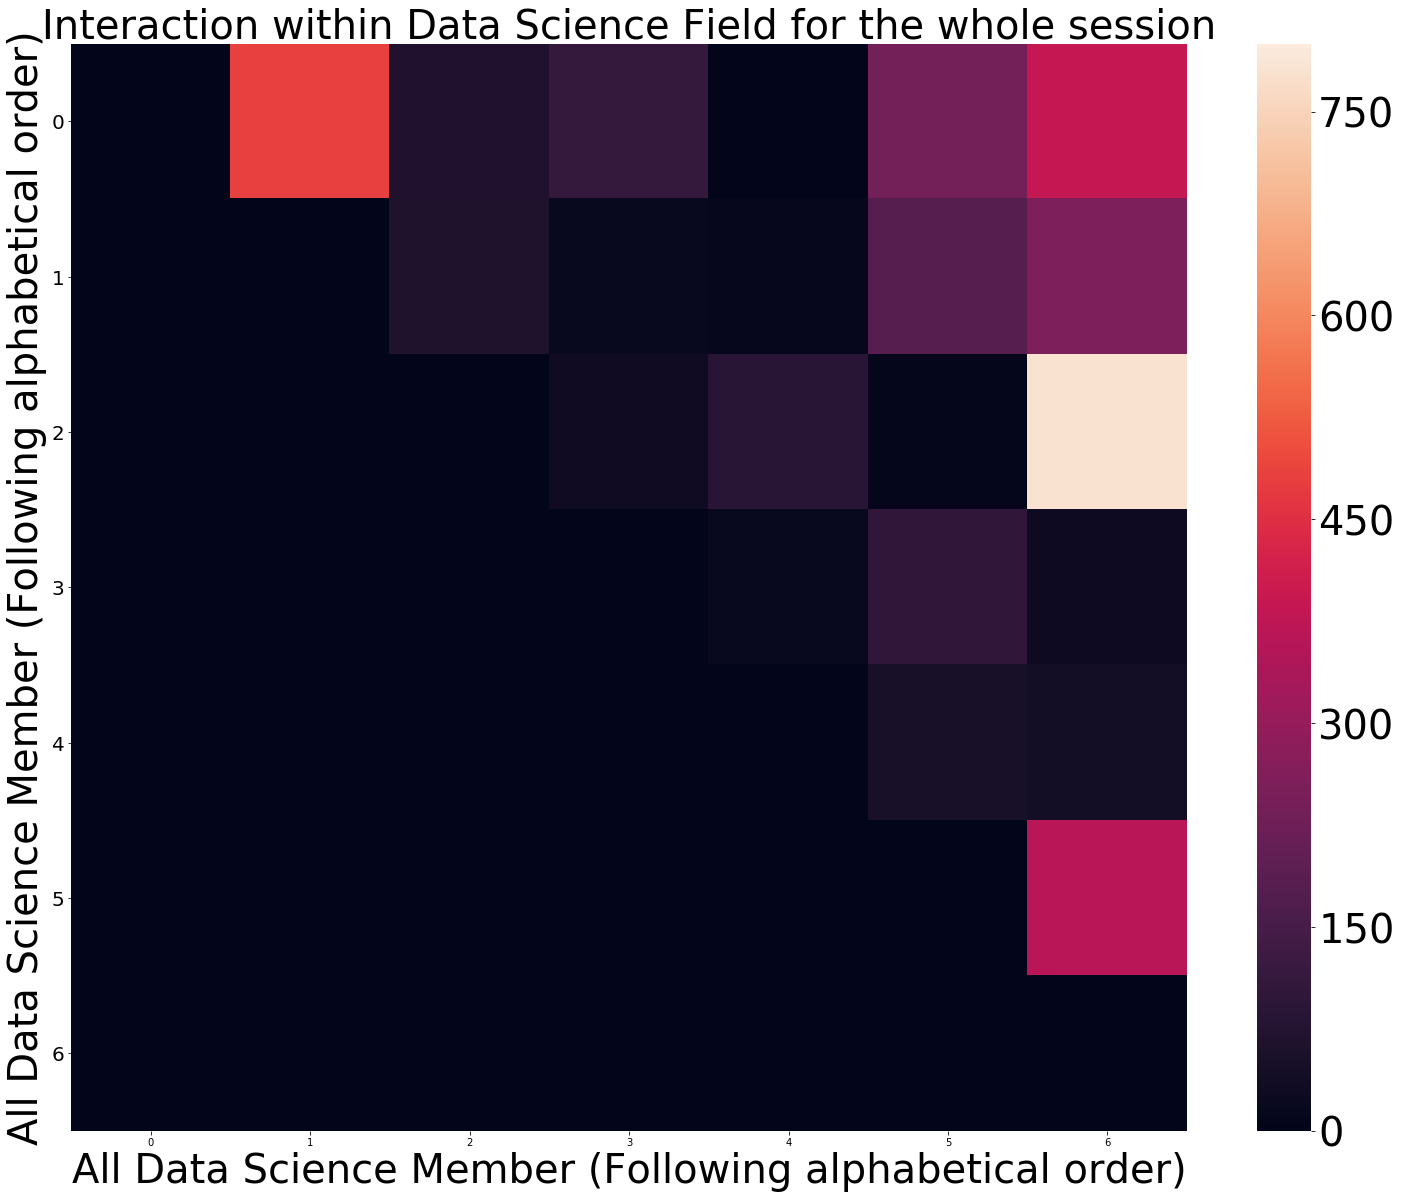

In [29]:
plt.figure(figsize = (25,20))
hm_copy_values = hm_copy.values.astype(str).astype(float)
ax = sns.heatmap(hm_copy_values,vmin=0, vmax=800)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=40)
ax.tick_params(axis='y',labelsize= 20,rotation =0)
plt.title('Interaction within Data Science Field for the whole session',fontsize = 40)
plt.xlabel('All Data Science Member (Following alphabetical order)', fontsize = 40)
plt.ylabel('All Data Science Member (Following alphabetical order)', fontsize = 40)

In [30]:
test = hm_copy.values.astype(str).astype(float)
self = []
for l in test.tolist():
    self += l

In [31]:
# get the target field with fields other than this field
drop_col_2 = []
target_major = 'Data Science'
hm_copy_2 = hm
for index,row in hm.iterrows():
    if name_major[index] == target_major:
        hm_copy_2 = hm_copy_2.drop(index)
        drop_col_2.append(index)
hm_copy_2 = hm_copy_2.drop(drop_col,axis = 1)

hm_copy_2 = hm_copy_2.transpose()

Text(0.5, 123.0, 'ALL Members other than Data Science Members')

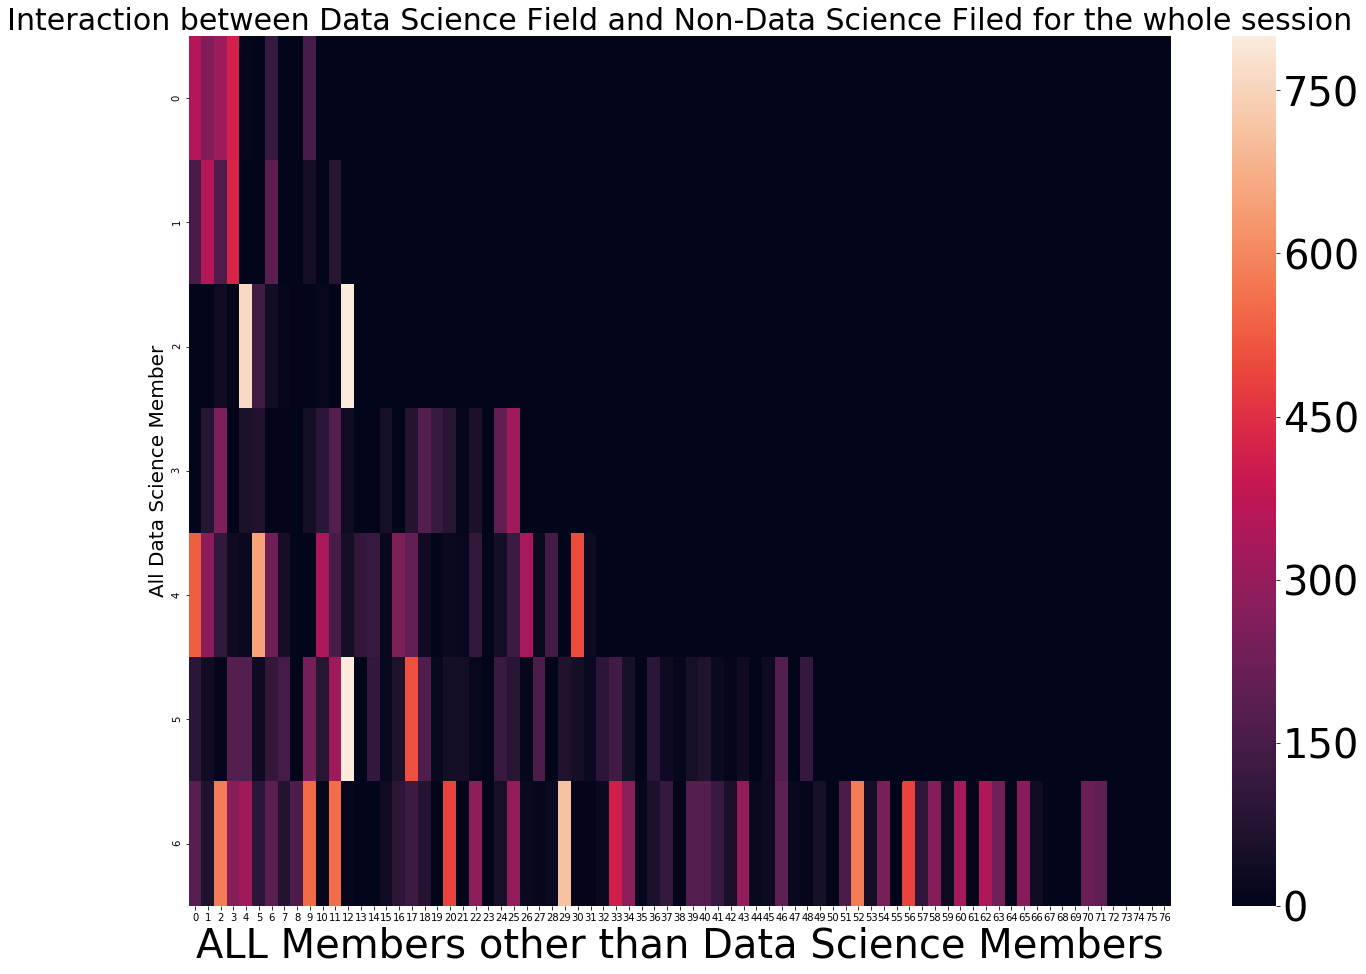

In [32]:
plt.figure(figsize = (22,16))
hm_copy_values_2 = hm_copy_2.values.astype(str).astype(float)
ax = sns.heatmap(hm_copy_values_2,vmin=0, vmax=800)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=40)
plt.title('Interaction between Data Science Field and Non-Data Science Filed for the whole session',fontsize = 30)
plt.ylabel('All Data Science Member', fontsize = 20)
plt.xlabel('ALL Members other than Data Science Members', fontsize = 40)

In [33]:
test_2 = hm_copy_2.values.astype(str).astype(float)
self_2 = []
for l in test_2.tolist():
    self_2 += l

# P-value for Comparison

In [34]:

# get p-values from each comparison

from scipy.stats import ttest_ind
name_major = dict(zip(background_affiliation['name'].values.astype('str').tolist(),
                      background_affiliation['background'].values.astype('str').tolist()))
hm['member_name'] = all_name
hm = hm.set_index('member_name')
unique_back = list(set(background_affiliation['background'].values.astype('str')))
all_p = []
for i in range(len(unique_back)):
    
    drop_col = []
    target_major = unique_back[i]
    hm_copy = hm
    for index,row in hm.iterrows():
        if name_major[index] != target_major:
            hm_copy = hm_copy.drop(index)
            drop_col.append(index)
    hm_copy = hm_copy.drop(drop_col,axis = 1)

    test = hm_copy.values.astype(str).astype(float)
    self = []
    for l in test.tolist():
        self += l

    drop_col_2 = []
    hm_copy_2 = hm
    for index,row in hm.iterrows():
        if name_major[index] == target_major:
            hm_copy_2 = hm_copy_2.drop(index)
            drop_col_2.append(index)
    hm_copy_2 = hm_copy_2.drop(drop_col,axis = 1)

    test_2 = hm_copy_2.values.astype(str).astype(float)
    self_2 = []
    for l in test_2.tolist():
        self_2 += l
    
    ttest,pval = ttest_ind(self,self_2)
    all_p.append(pval)
back_pvalue = dict(zip(unique_back,all_p))

In [35]:
ordered_key = []
ordered_value = []
for key in back_pvalue:
    ordered_key.append(key)
    ordered_value.append(back_pvalue[key])
    

Text(0.5, 0, 'P-values')

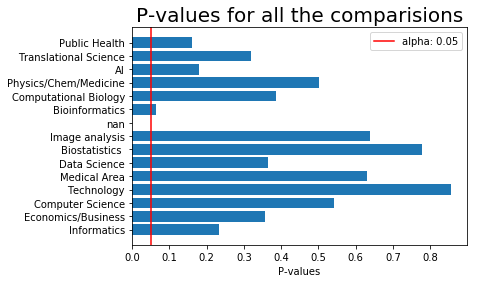

In [36]:
plt.barh(ordered_key,ordered_value)
plt.axvline(x=0.05,color = 'red',label = 'alpha: 0.05')
plt.legend()
plt.title('P-values for all the comparisions', fontsize = 20)
plt.xlabel('P-values')